# Analisis Data: Data Dictionary, Kualitas Data, EDA, & Representativitas

1. Data dictionary (variabel, tipe, contoh nilai, unit)
2. Kualitas data (missing, outlier, duplikasi)
3. EDA berinsight (distribusi & korelasi)
4. Representativitas & potensi bias sampel

In [48]:
# Imports dan memuat data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from scipy import stats

df = pd.read_csv('laptop_price.csv', encoding='latin-1')

print("=== DATA QUALITY ASSESSMENT ===")
print(f"Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")

# Check data types
print(f"\nData Types:\n{df.dtypes}")

=== DATA QUALITY ASSESSMENT ===
Shape: (1303, 13)
Missing Values:
laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64
Duplicates: 0

Data Types:
laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price_euros         float64
dtype: object


### Cek Unique Data

In [49]:
categorical_cols = ['Company', 'TypeName', 'OpSys']
for col in categorical_cols:
    print(f"\nUnique {col}: {df[col].nunique()}")
    print(df[col].value_counts().head())


Unique Company: 19
Company
Dell      297
Lenovo    297
HP        274
Asus      158
Acer      103
Name: count, dtype: int64

Unique TypeName: 6
TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Name: count, dtype: int64

Unique OpSys: 9
OpSys
Windows 10    1072
No OS           66
Linux           62
Windows 7       45
Chrome OS       27
Name: count, dtype: int64


### Data Cleaning dan Preparation

#### convert ram n weight to numeric

In [50]:
# Convert Ram to numeric
df['Ram_GB'] = df['Ram'].str.replace('GB', '').astype(int)

# Convert Weight to numeric
df['Weight_kg'] = df['Weight'].str.replace('kg', '').astype(float)

#### Extract screen resolution information

In [51]:
df['Resolution_Width'] = df['ScreenResolution'].str.extract(r'(\d+)x\d+').astype(float)
df['Resolution_Height'] = df['ScreenResolution'].str.extract(r'\d+x(\d+)').astype(float)
df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False)
df['IPS'] = df['ScreenResolution'].str.contains('IPS', case=False)

#### Extract CPU information

In [52]:
df['CPU_Brand'] = df['Cpu'].str.split().str[0]
df['CPU_Speed_GHz'] = df['Cpu'].str.extract(r'(\d+\.\d+)GHz').astype(float)

#### Extract GPU information

In [53]:
df['GPU_Brand'] = df['Gpu'].str.split().str[0]

#### Extract memory information

In [54]:
def parse_memory(memory):
    """
    Parse memory string to extract storage in GB
    Handles formats like:
    - "128GB SSD"
    - "1TB HDD"
    - "128GB SSD +  1TB HDD"
    - "256GB Flash Storage"
    """
    try:
        if pd.isna(memory):
            return 0
        
        total_gb = 0
        
        parts = str(memory).split('+')
        
        for part in parts:
            part = part.strip()
            
            if 'TB' in part:
                tb_value = part.split('TB')[0].strip()
                numbers = ''.join(filter(str.isdigit, tb_value))
                if numbers:
                    total_gb += float(numbers) * 1024
            elif 'GB' in part:
                gb_value = part.split('GB')[0].strip()
                numbers = ''.join(filter(str.isdigit, gb_value))
                if numbers:
                    total_gb += float(numbers)
        
        return total_gb
    except:
        return 0

def parse_ssd(memory):
    """Extract only SSD storage"""
    try:
        if pd.isna(memory):
            return 0
        
        ssd_gb = 0
        parts = str(memory).split('+')
        
        for part in parts:
            part = part.strip()
            if 'SSD' in part:
                if 'TB' in part:
                    tb_value = part.split('TB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, tb_value))
                    if numbers:
                        ssd_gb += float(numbers) * 1024
                elif 'GB' in part:
                    gb_value = part.split('GB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, gb_value))
                    if numbers:
                        ssd_gb += float(numbers)
        
        return ssd_gb
    except:
        return 0

def parse_hdd(memory):
    """Extract only HDD storage"""
    try:
        if pd.isna(memory):
            return 0
        
        hdd_gb = 0
        parts = str(memory).split('+')
        
        for part in parts:
            part = part.strip()
            if 'HDD' in part:
                if 'TB' in part:
                    tb_value = part.split('TB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, tb_value))
                    if numbers:
                        hdd_gb += float(numbers) * 1024
                elif 'GB' in part:
                    gb_value = part.split('GB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, gb_value))
                    if numbers:
                        hdd_gb += float(numbers)
        
        return hdd_gb
    except:
        return 0

def parse_flash(memory):
    """Extract only Flash storage"""
    try:
        if pd.isna(memory):
            return 0
        
        flash_gb = 0
        parts = str(memory).split('+')
        
        for part in parts:
            part = part.strip()
            if 'Flash' in part:
                if 'TB' in part:
                    tb_value = part.split('TB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, tb_value))
                    if numbers:
                        flash_gb += float(numbers) * 1024
                elif 'GB' in part:
                    gb_value = part.split('GB')[0].strip()
                    numbers = ''.join(filter(str.isdigit, gb_value))
                    if numbers:
                        flash_gb += float(numbers)
        
        return flash_gb
    except:
        return 0

df['Total_Storage_GB'] = df['Memory'].apply(parse_memory)
df['SSD_GB'] = df['Memory'].apply(parse_ssd)
df['HDD_GB'] = df['Memory'].apply(parse_hdd)
df['Flash_Storage_GB'] = df['Memory'].apply(parse_flash)

#### Data setelah di cleaning

In [55]:
print("\n=== DATA AFTER CLEANING ===")
print(f"Sample of Memory parsing:")
sample_data = df[['Memory', 'Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_Storage_GB']].head(10)
print(sample_data.to_string())

print(f"\nBasic Statistics:")
print(df[['Ram_GB', 'Weight_kg', 'Resolution_Width', 'CPU_Speed_GHz', 'Total_Storage_GB']].describe())


=== DATA AFTER CLEANING ===
Sample of Memory parsing:
                Memory  Total_Storage_GB  SSD_GB  HDD_GB  Flash_Storage_GB
0            128GB SSD             128.0   128.0     0.0               0.0
1  128GB Flash Storage             128.0     0.0     0.0             128.0
2            256GB SSD             256.0   256.0     0.0               0.0
3            512GB SSD             512.0   512.0     0.0               0.0
4            256GB SSD             256.0   256.0     0.0               0.0
5            500GB HDD             500.0     0.0   500.0               0.0
6  256GB Flash Storage             256.0     0.0     0.0             256.0
7  256GB Flash Storage             256.0     0.0     0.0             256.0
8            512GB SSD             512.0   512.0     0.0               0.0
9            256GB SSD             256.0   256.0     0.0               0.0

Basic Statistics:
            Ram_GB    Weight_kg  Resolution_Width  CPU_Speed_GHz  \
count  1303.000000  1303.000000  

In [56]:
print("=== MEMORY PARSING VERIFICATION ===")

problematic_cases = [
    "128GB SSD +  1TB HDD",
    "256GB SSD",
    "1TB HDD",
    "512GB SSD +  512GB SSD",
    "128GB Flash Storage"
]

for case in problematic_cases:
    total = parse_memory(case)
    ssd = parse_ssd(case)
    hdd = parse_hdd(case)
    flash = parse_flash(case)
    print(f"'{case}' -> Total: {total}GB, SSD: {ssd}GB, HDD: {hdd}GB, Flash: {flash}GB")

zero_storage = df[df['Total_Storage_GB'] == 0]
print(f"\nRows with 0 storage (should investigate): {len(zero_storage)}")
if len(zero_storage) > 0:
    print(zero_storage[['Memory', 'Total_Storage_GB']].head())

=== MEMORY PARSING VERIFICATION ===
'128GB SSD +  1TB HDD' -> Total: 1152.0GB, SSD: 128.0GB, HDD: 1024.0GB, Flash: 0GB
'256GB SSD' -> Total: 256.0GB, SSD: 256.0GB, HDD: 0GB, Flash: 0GB
'1TB HDD' -> Total: 1024.0GB, SSD: 0GB, HDD: 1024.0GB, Flash: 0GB
'512GB SSD +  512GB SSD' -> Total: 1024.0GB, SSD: 1024.0GB, HDD: 0GB, Flash: 0GB
'128GB Flash Storage' -> Total: 128.0GB, SSD: 0GB, HDD: 0GB, Flash: 128.0GB

Rows with 0 storage (should investigate): 0


#### DATA PREPARATION UNTUK CLUSTERING

##### 1. Pilih fitur yang relevan untuk clustering

In [57]:
clustering_features = [
    'Inches', 'Ram_GB', 'Weight_kg', 'Resolution_Width', 'CPU_Speed_GHz',
    'Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_Storage_GB',
    
    'Price_euros',
    
    'Touchscreen', 'IPS'
]

X_cluster = df[clustering_features].copy()

print(f"Shape data untuk clustering: {X_cluster.shape}")
print(f"Features: {list(X_cluster.columns)}")

Shape data untuk clustering: (1303, 12)
Features: ['Inches', 'Ram_GB', 'Weight_kg', 'Resolution_Width', 'CPU_Speed_GHz', 'Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Price_euros', 'Touchscreen', 'IPS']


##### 2. Preprocessing untuk clustering

###### Identifikasi tipe data masing masing fitur

In [58]:
numerical_features = ['Inches', 'Ram_GB', 'Weight_kg', 'Resolution_Width', 
                     'CPU_Speed_GHz', 'Total_Storage_GB', 'SSD_GB', 'HDD_GB', 
                     'Flash_Storage_GB', 'Price_euros']

boolean_features = ['Touchscreen', 'IPS']

###### Normalisasi fitur numerik

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster[numerical_features])

###### Convert boolean to integer (0/1) dan gabungkan semua fitur

In [60]:
X_boolean = X_cluster[boolean_features].astype(int).values

X_processed = np.column_stack([X_scaled, X_boolean])

print(f"Data sebelum scaling: {X_cluster[numerical_features].shape}")
print(f"Data setelah scaling: {X_processed.shape}")
print(f"Feature names setelah processing: {numerical_features + boolean_features}")
print("✅ DATA PREPARATION UNTUK CLUSTERING SELESAI")
print("✅ Data siap untuk analisis clustering selanjutnya")

Data sebelum scaling: (1303, 10)
Data setelah scaling: (1303, 12)
Feature names setelah processing: ['Inches', 'Ram_GB', 'Weight_kg', 'Resolution_Width', 'CPU_Speed_GHz', 'Total_Storage_GB', 'SSD_GB', 'HDD_GB', 'Flash_Storage_GB', 'Price_euros', 'Touchscreen', 'IPS']
✅ DATA PREPARATION UNTUK CLUSTERING SELESAI
✅ Data siap untuk analisis clustering selanjutnya


In [61]:
from sklearn.impute import SimpleImputer
import numpy as np


imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_processed_imputed = imputer.fit_transform(X_processed)
X_processed = X_processed_imputed 


##### Menentukan Jumlah Klaster Optimal (Elbow Method & Silhouette)

=== MENCARI JUMLAH KLASTER OPTIMAL ===
K=2, Silhouette Score=0.2232
K=3, Silhouette Score=0.2295
K=4, Silhouette Score=0.2606
K=5, Silhouette Score=0.2691
K=6, Silhouette Score=0.2702
K=7, Silhouette Score=0.2678
K=8, Silhouette Score=0.2461
K=9, Silhouette Score=0.2392
K=10, Silhouette Score=0.2388


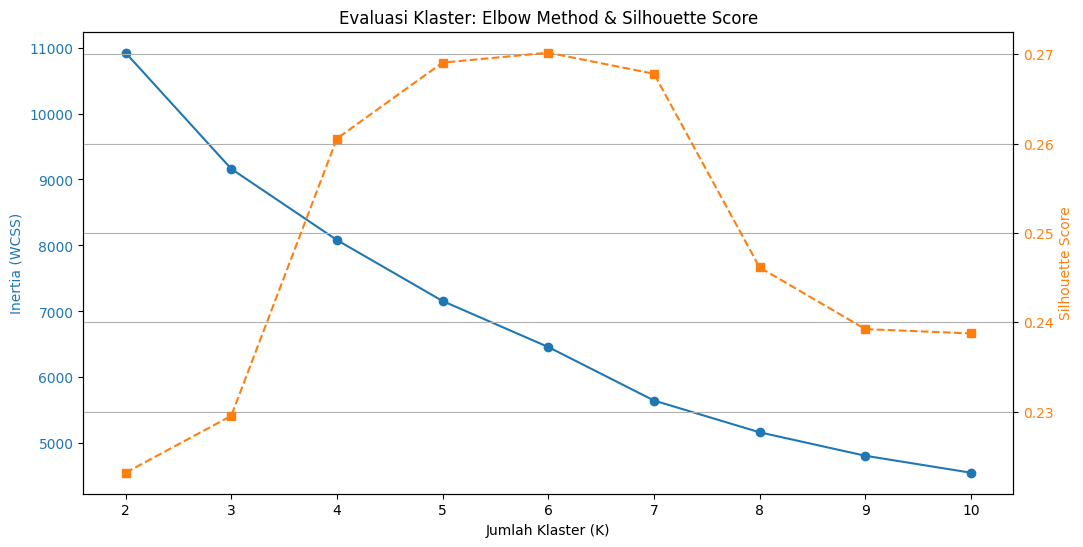

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

inertia = []
silhouette_scores = []
K_range = range(2, 11)

print("=== MENCARI JUMLAH KLASTER OPTIMAL ===")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    
    inertia.append(kmeans.inertia_)
    
    score = silhouette_score(X_processed, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Jumlah Klaster (K)')
ax1.set_ylabel('Inertia (WCSS)', color='tab:blue')
ax1.plot(K_range, inertia, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:orange')
ax2.plot(K_range, silhouette_scores, marker='s', color='tab:orange', linestyle='--', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Evaluasi Klaster: Elbow Method & Silhouette Score')
plt.grid(True)
plt.show()

#### Modeling (Final Model)

In [63]:

optimal_k = 3 

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_processed)


df['Cluster'] = cluster_labels


#### Business Evaluation (Profiling/Interpretasi)


=== PROFIL SETIAP SEGMEN (Rata-rata) ===
   Cluster  Price_euros  Ram_GB  SSD_GB  CPU_Speed_GHz  Resolution_Width  \
1        1       728.47    6.33   76.05           2.31           1699.23   
0        0      1206.01    7.55  240.18           2.14           1972.24   
2        2      2149.69   16.97  377.40           2.71           2307.63   

   Count  
1    608  
0    501  
2    194  


C:\Users\M.S.I\AppData\Local\Temp\ipykernel_15408\528673997.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Price_euros', data=df, palette='viridis')


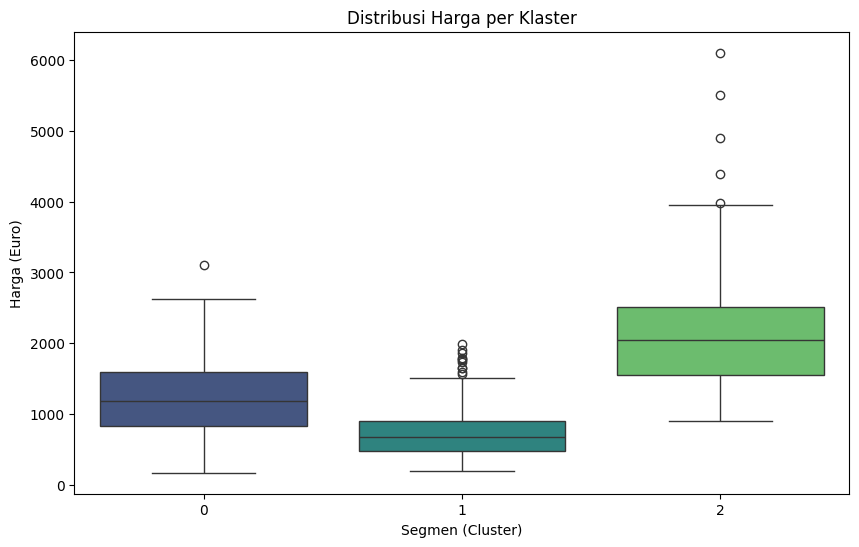

In [64]:
cluster_summary = df.groupby('Cluster')[['Price_euros', 'Ram_GB', 'SSD_GB', 'CPU_Speed_GHz', 'Resolution_Width']].mean().reset_index()
cluster_count = df['Cluster'].value_counts().reset_index()
cluster_count.columns = ['Cluster', 'Count']

cluster_profile = cluster_summary.merge(cluster_count, on='Cluster')

cluster_profile = cluster_profile.sort_values(by='Price_euros')

print("\n=== PROFIL SETIAP SEGMEN (Rata-rata) ===")
print(cluster_profile.round(2))

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Price_euros', data=df, palette='viridis')
plt.title('Distribusi Harga per Klaster')
plt.xlabel('Segmen (Cluster)')
plt.ylabel('Harga (Euro)')
plt.show()

### EDA

#### Distribusi Harga Laptop

Text(0, 0.5, 'Frekuensi')

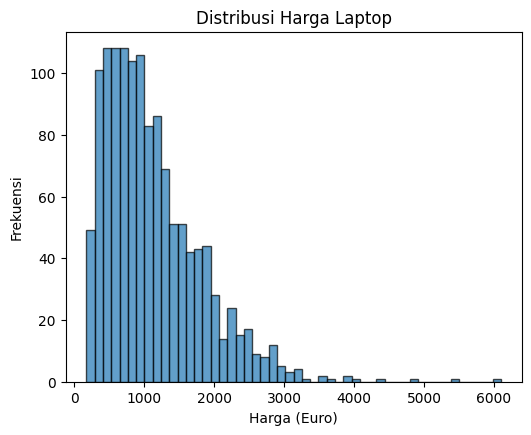

In [65]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Price_euros'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribusi Harga Laptop')
plt.xlabel('Harga (Euro)')
plt.ylabel('Frekuensi')

#### Harga berdasarkan company

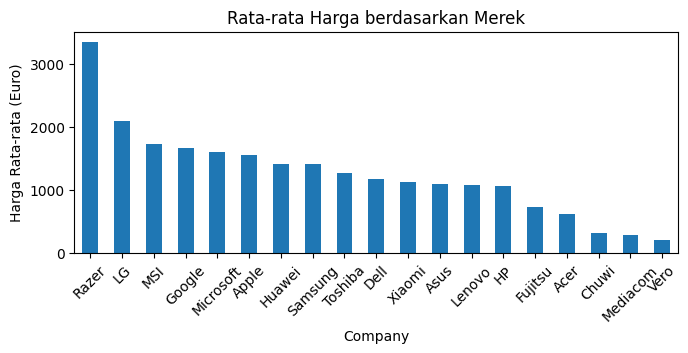

In [66]:
plt.figure(figsize=(20,6))
plt.subplot(2, 3, 2)
company_price = df.groupby('Company')['Price_euros'].mean().sort_values(ascending=False)
company_price.plot(kind='bar')
plt.title('Rata-rata Harga berdasarkan Merek')
plt.xticks(rotation=45)
plt.ylabel('Harga Rata-rata (Euro)')
plt.tight_layout()

#### Harga berdasarkan tipe

Text(0, 0.5, 'Harga Rata-rata (Euro)')

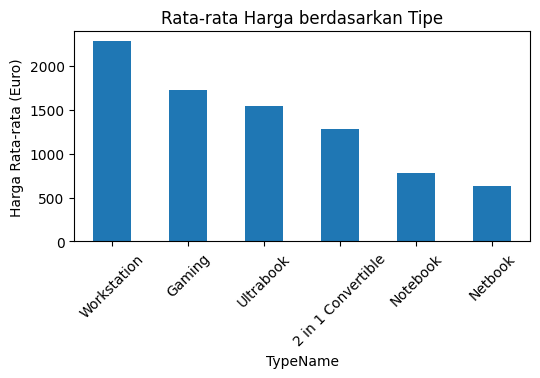

In [67]:
plt.figure(figsize=(20,6))

plt.subplot(2, 3, 3)
type_price = df.groupby('TypeName')['Price_euros'].mean().sort_values(ascending=False)
type_price.plot(kind='bar')
plt.title('Rata-rata Harga berdasarkan Tipe')
plt.xticks(rotation=45)
plt.ylabel('Harga Rata-rata (Euro)')

#### Korelasi antara RAM dan Harga

Text(0, 0.5, 'Harga (Euro)')

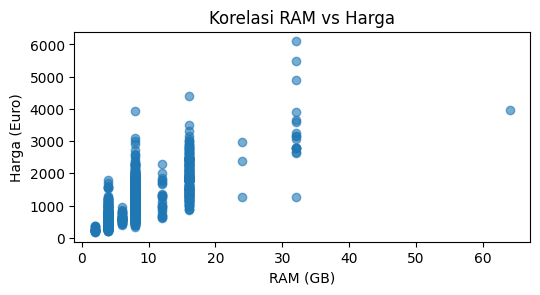

In [68]:
plt.figure(figsize=(20,6))
plt.subplot(2, 3, 4)
plt.scatter(df['Ram_GB'], df['Price_euros'], alpha=0.6)
plt.title('Korelasi RAM vs Harga')
plt.xlabel('RAM (GB)')
plt.ylabel('Harga (Euro)')

#### Harga berdasarkan total storage

Text(0, 0.5, 'Harga (Euro)')

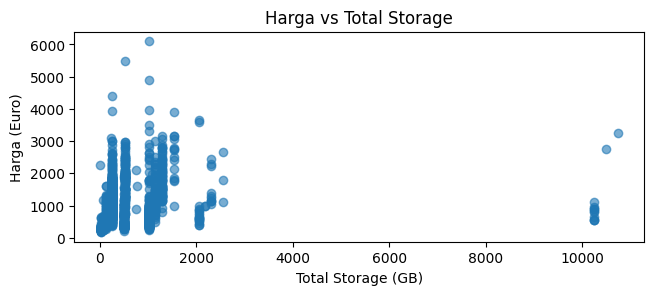

In [69]:
plt.figure(figsize=(25,6))

plt.subplot(2, 3, 5)
plt.scatter(df['Total_Storage_GB'], df['Price_euros'], alpha=0.6)
plt.title('Harga vs Total Storage')
plt.xlabel('Total Storage (GB)')
plt.ylabel('Harga (Euro)')

#### Distribusi berat

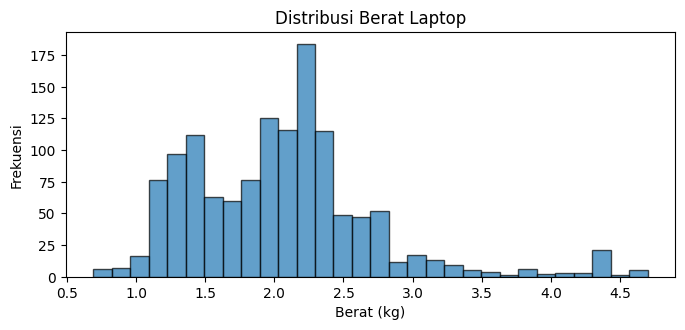

In [70]:
plt.figure(figsize=(20, 6))
plt.subplot(2, 3, 6)
plt.hist(df['Weight_kg'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribusi Berat Laptop')
plt.xlabel('Berat (kg)')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

#### Analisis Kolerasi

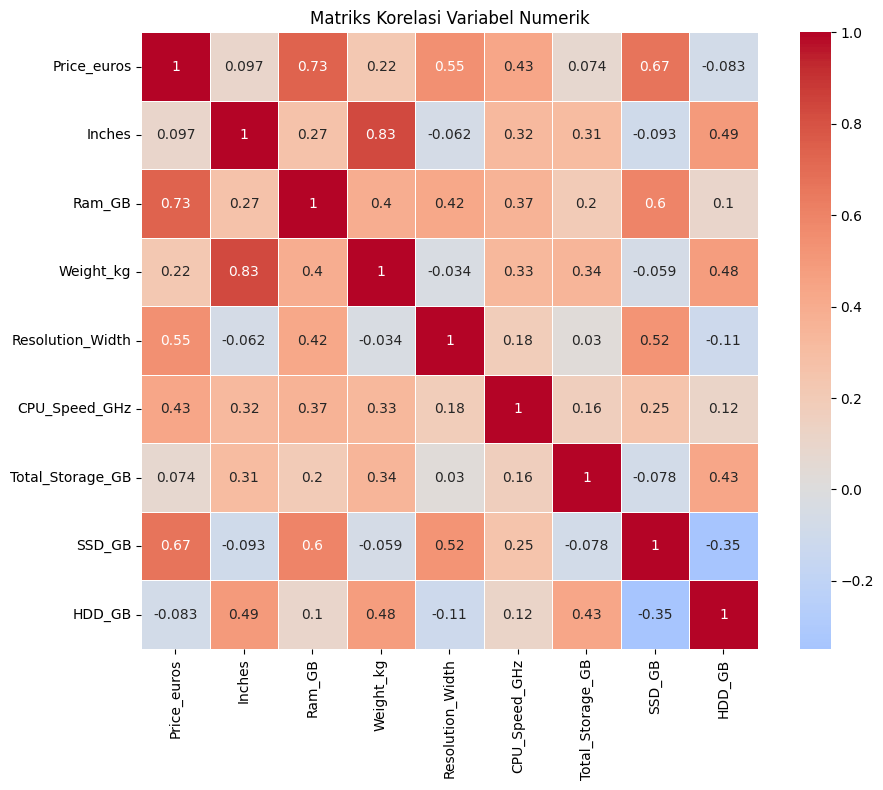

Korelasi dengan Harga:
Price_euros         1.000000
Ram_GB              0.733490
SSD_GB              0.667136
Resolution_Width    0.546216
CPU_Speed_GHz       0.432642
Weight_kg           0.220692
Inches              0.096985
Total_Storage_GB    0.073824
HDD_GB             -0.083149
Name: Price_euros, dtype: float64


In [71]:
numeric_cols = ['Price_euros', 'Inches', 'Ram_GB', 'Weight_kg', 'Resolution_Width', 
                'CPU_Speed_GHz', 'Total_Storage_GB', 'SSD_GB', 'HDD_GB']

df_numeric = df[numeric_cols].dropna()

plt.figure(figsize=(10, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, linewidths=0.5)
plt.title('Matriks Korelasi Variabel Numerik')
plt.tight_layout()
plt.show()

print("Korelasi dengan Harga:")
price_corr = correlation_matrix['Price_euros'].sort_values(ascending=False)
print(price_corr)

#### Analisis mendalam berdasarkan kategori

##### 1. Distribusi harga per perusahaan dengan boxplot

Text(0.5, 1.0, 'Distribusi Harga per Perusahaan (Top 8)')

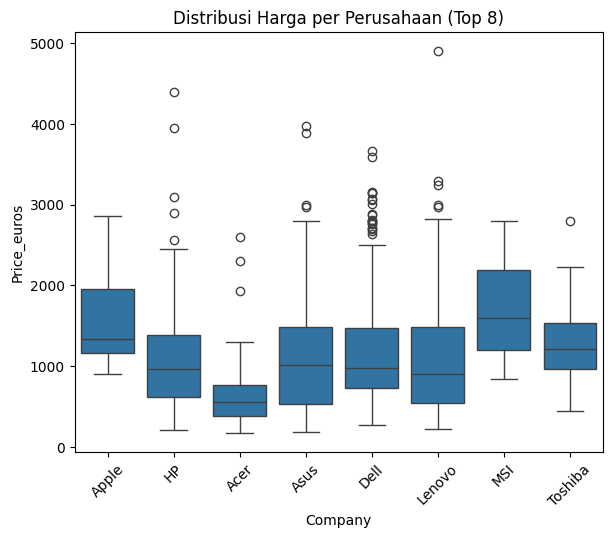

In [72]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
top_companies = df['Company'].value_counts().head(8).index
df_top = df[df['Company'].isin(top_companies)]
sns.boxplot(data=df_top, x='Company', y='Price_euros')
plt.xticks(rotation=45)
plt.title('Distribusi Harga per Perusahaan (Top 8)')

##### 2. Pengaruh Touchscreen terhadap harga

Text(0.5, 1.0, 'Pengaruh Touchscreen terhadap Harga')

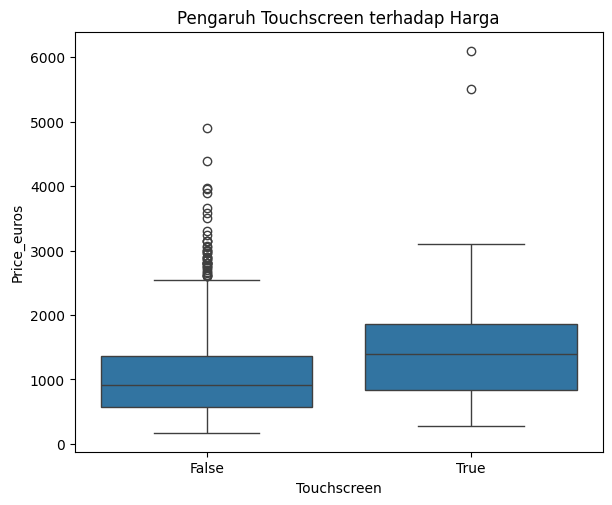

In [73]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Touchscreen', y='Price_euros')
plt.title('Pengaruh Touchscreen terhadap Harga')

##### 3. Pengaruh IPS terhadap harga

Text(0.5, 1.0, 'Pengaruh IPS Panel terhadap Harga')

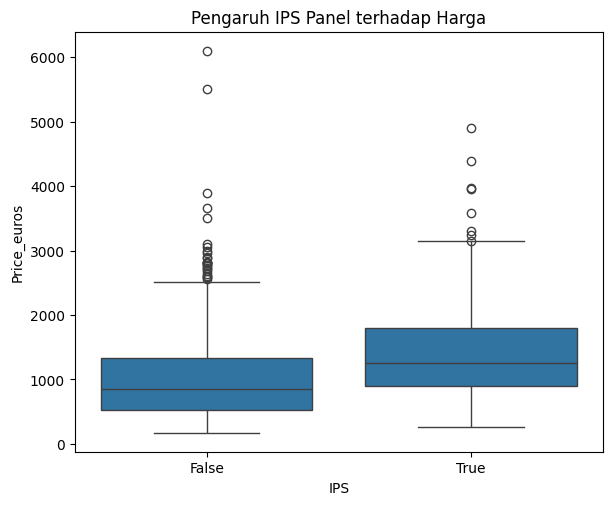

In [74]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='IPS', y='Price_euros')
plt.title('Pengaruh IPS Panel terhadap Harga')

##### 4. Distribusi harga berdasarkan tipe storage

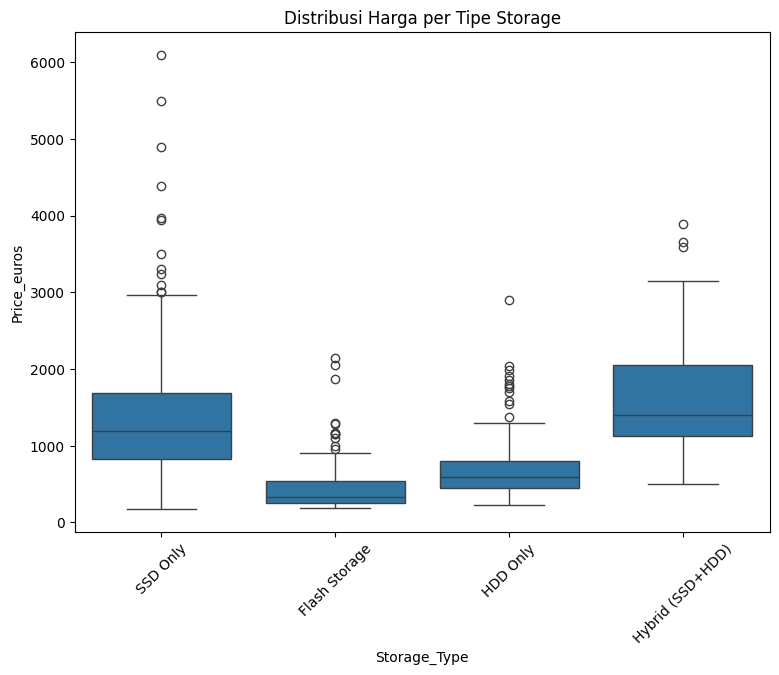

In [75]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 4)
def get_storage_type(row):
    if row['SSD_GB'] > 0 and row['HDD_GB'] > 0:
        return 'Hybrid (SSD+HDD)'
    elif row['SSD_GB'] > 0:
        return 'SSD Only'
    elif row['HDD_GB'] > 0:
        return 'HDD Only'
    elif row['Flash_Storage_GB'] > 0:
        return 'Flash Storage'
    else:
        return 'Unknown'

df['Storage_Type'] = df.apply(get_storage_type, axis=1)
sns.boxplot(data=df[df['Storage_Type'] != 'Unknown'], x='Storage_Type', y='Price_euros')
plt.xticks(rotation=45)
plt.title('Distribusi Harga per Tipe Storage')

plt.tight_layout()
plt.show()


#### KEY INSIGHT

##### 1. Faktor yang paling mempengaruhi harga

In [ ]:
print("=== KEY INSIGHTS ===")
print("1. FAKTOR PENENTU HARGA:")
print(f"   - RAM: korelasi = {df['Ram_GB'].corr(df['Price_euros']):.3f}")
print(f"   - SSD: korelasi = {df['SSD_GB'].corr(df['Price_euros']):.3f}")
print(f"   - Resolusi: korelasi = {df['Resolution_Width'].corr(df['Price_euros']):.3f}")

=== KEY INSIGHTS ===
1. FAKTOR PENENTU HARGA:
   - RAM: korelasi = 0.743
   - SSD: korelasi = 0.671
   - Resolusi: korelasi = 0.557


##### 2. Segmentasi pasar

In [77]:
print("=== KEY INSIGHTS ===")
print("\n2. SEGMENTASI PASAR:")
for type_name in ['Gaming', 'Ultrabook', 'Notebook', '2 in 1 Convertible']:
    if type_name in df['TypeName'].values:
        avg_price = df[df['TypeName'] == type_name]['Price_euros'].mean()
        count = len(df[df['TypeName'] == type_name])
        print(f"   - {type_name}: €{avg_price:.2f} ({count} units)")

=== KEY INSIGHTS ===

2. SEGMENTASI PASAR:
   - Gaming: €1731.38 (205 units)
   - Ultrabook: €1548.23 (196 units)
   - Notebook: €782.08 (727 units)
   - 2 in 1 Convertible: €1282.40 (121 units)


##### 3. Trend teknologi

In [78]:
print("=== KEY INSIGHTS ===")
print("\n3. TREND TEKNOLOGI:")
touchscreen_ratio = df['Touchscreen'].mean() * 100
ips_ratio = df['IPS'].mean() * 100
ssd_ratio = (df['SSD_GB'] > 0).mean() * 100
print(f"   - {touchscreen_ratio:.1f}% laptop memiliki touchscreen")
print(f"   - {ips_ratio:.1f}% laptop memiliki IPS panel")
print(f"   - {ssd_ratio:.1f}% laptop menggunakan SSD")

=== KEY INSIGHTS ===

3. TREND TEKNOLOGI:
   - 14.7% laptop memiliki touchscreen
   - 28.0% laptop memiliki IPS panel
   - 64.7% laptop menggunakan SSD


##### 4. Value for money analysis

In [79]:
print("=== KEY INSIGHTS ===")
df['Price_per_GB_RAM'] = df['Price_euros'] / df['Ram_GB']
df['Price_per_GB_SSD'] = df['Price_euros'] / df['SSD_GB'].replace(0, np.nan)

best_value_ram = df.nsmallest(5, 'Price_per_GB_RAM')[['Company', 'Product', 'Ram_GB', 'Price_euros', 'Price_per_GB_RAM']]
print("\n4. BEST VALUE FOR MONEY (berdasarkan RAM):")
print(best_value_ram.to_string(index=False))

=== KEY INSIGHTS ===

4. BEST VALUE FOR MONEY (berdasarkan RAM):
Company                         Product  Ram_GB  Price_euros  Price_per_GB_RAM
   Asus G701VO-IH74K (i7-6820HK/32GB/2x      32       1279.0          39.96875
 Lenovo               IdeaPad 110-15IBR       8        329.0          41.12500
   Acer                   Aspire E5-475       8        389.0          48.62500
     HP  15-AY023na (N3710/8GB/2TB/W10)       8        389.0          48.62500
     HP  14-am079na (N3710/8GB/2TB/W10)       8        389.0          48.62500
